<a href="https://colab.research.google.com/github/mashaan14/YouTube-channel/blob/main/notebooks/2024_02_20_jraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Convolutional Network (GCN) in PyTorch-Geometric and Jraph

## YouTube:
I explained this notebook in a [YouTube video](https://youtu.be/W-JDqd5AFio).

## <font color='red'>Disclaimer</font>
<font color='red'>The results I'm getting on CORA test set are not consistent for PyTorch-Geometric and Jraph (check the last two cells). So, please don't use this code in production. </font>

## Acknowledgment:
I borrowed some code from [pytorch-geometric tutorials](https://pytorch-geometric.readthedocs.io/en/latest/get_started/colabs.html) and [Interactive Jraph Colabs](https://github.com/google-deepmind/educational/blob/master/colabs/summer_schools/intro_to_graph_nets_tutorial_with_jraph.ipynb)

## References:
```bibtex
@inproceedings{Fey/Lenssen/2019,
  title={Fast Graph Representation Learning with {PyTorch Geometric}},
  author={Fey, Matthias and Lenssen, Jan E.},
  booktitle={ICLR Workshop on Representation Learning on Graphs and Manifolds},
  year={2019},
}
```

```bibtex
@software{jraph2020github,
  author = {Jonathan Godwin* and Thomas Keck* and Peter Battaglia and Victor Bapst and Thomas Kipf and Yujia Li and Kimberly Stachenfeld and Petar Veli\v{c}kovi\'{c} and Alvaro Sanchez-Gonzalez},
  title = {{J}raph: {A} library for graph neural networks in jax.},
  url = {http://github.com/deepmind/jraph},
  version = {0.0.1.dev},
  year = {2020},
}
```

##DL and GNN libraries

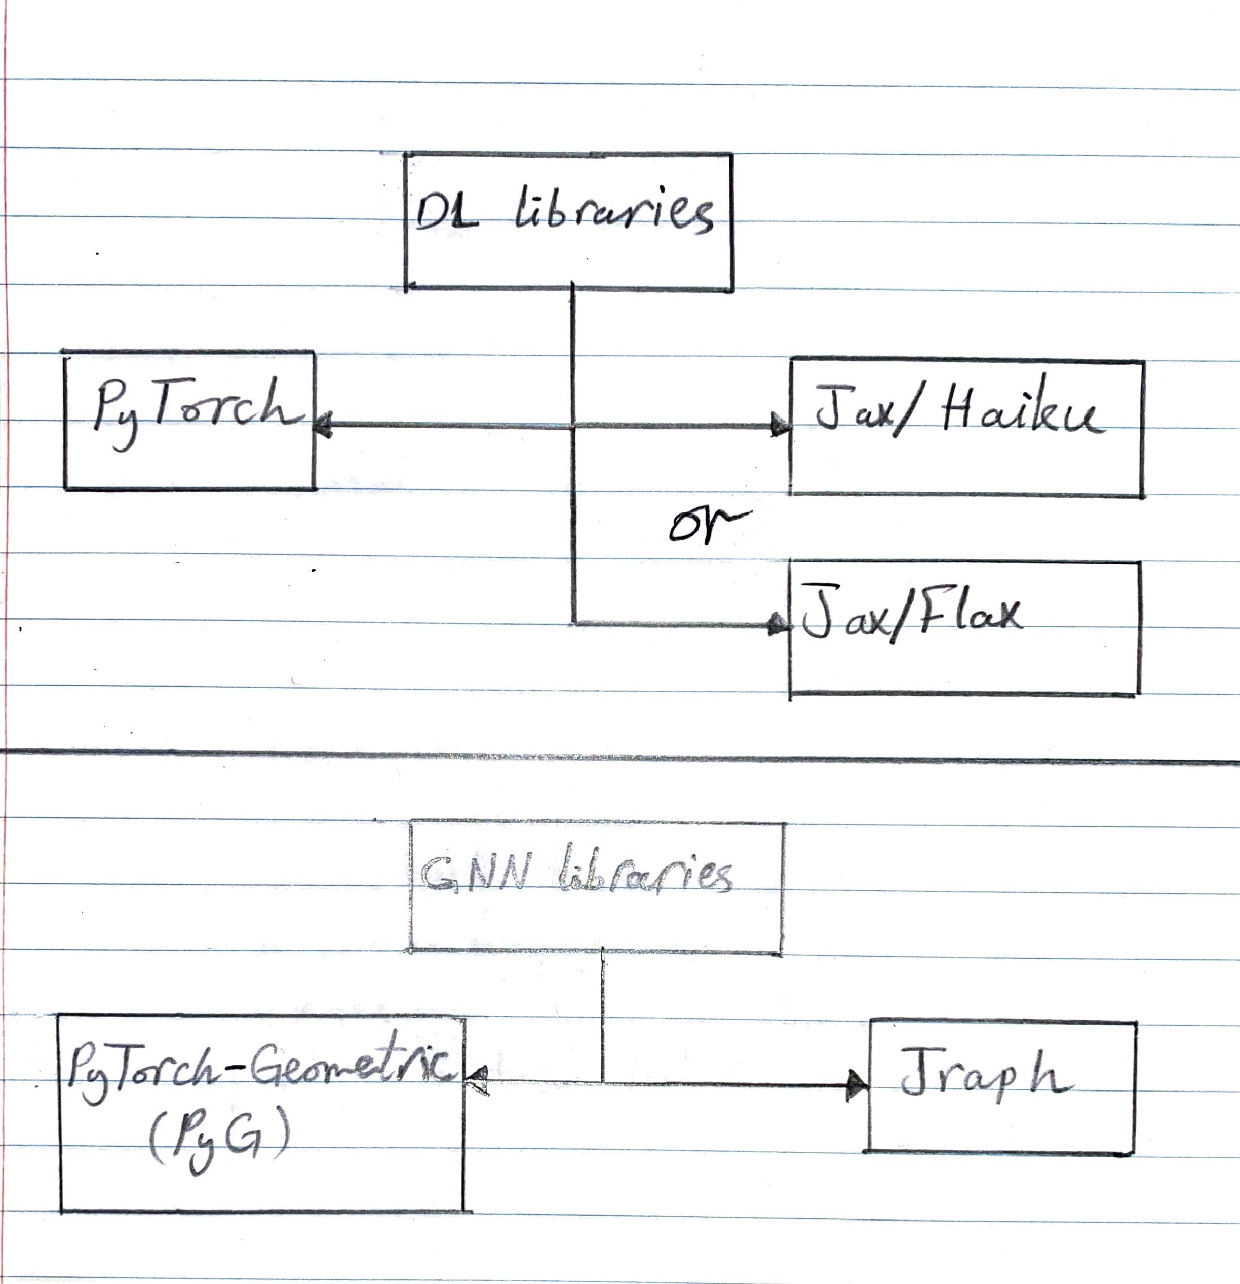

## PyG vs Jraph

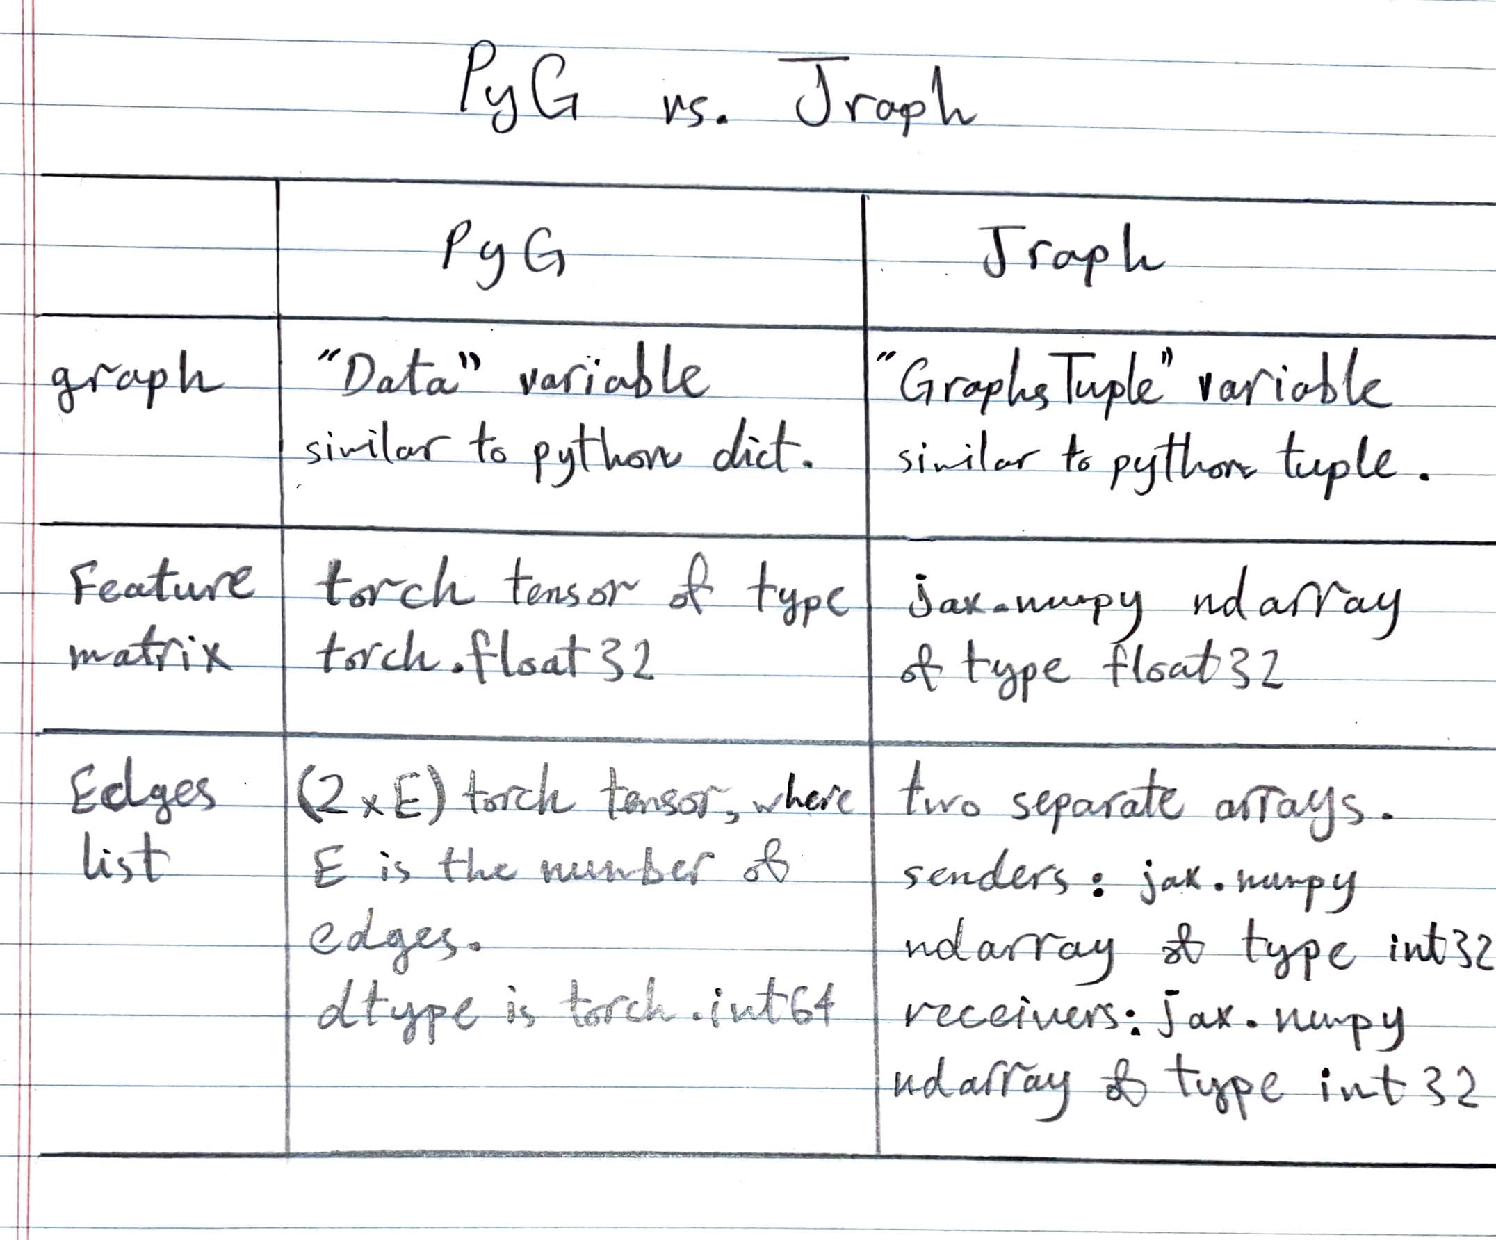

## Install Dependencies

In [ ]:
# install pytorch_geometric
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# install jraph and jax dependencies
!pip install git+https://github.com/deepmind/jraph.git
!pip install flax
!pip install dm-haiku

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/deepmind/jraph.git to /tmp/pip-req-build-5g86d13n
  Running command git clone --filter=blob:none --quiet https://github.com/deepmind/jraph.git /tmp/pip-req-build-5g86d13n
  Resolved https://github.com/deepmind/jraph.git to commit 51f5990104f7374492f8f3ea1cbc47feb411c69c
  Preparing metadata (setup.py) ... done


## Import libraries

In [ ]:
# Standard libraries
import numpy as np
from scipy import sparse
import seaborn as sns
import pandas as pd

# Plotting libraries
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib import cm
from IPython.display import Javascript  # Restrict height of output cell.

# PyTorch
import torch
import torch.nn.functional as F
from torch.nn import Linear

# PyTorch geometric
from torch_geometric.utils import from_scipy_sparse_matrix
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import (Planetoid, KarateClub)
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.data import Data
from torch_geometric import seed_everything

# jax
import jax
import jax.numpy as jnp
import jax.tree_util as tree
import flax
import haiku as hk
import optax
import pickle
from typing import Any, Callable, Dict, List, Optional, Tuple

# jraph
import jraph
from jraph._src import models as jraph_models

In [ ]:
random_seed = 42
torch.manual_seed(1234567)
seed_everything(42)
plt.style.use('dark_background')
accuracy_list = []
num_epochs = 101

## Karate Club Dataset
You can find a description of this dataset in [Pytorch-Geometric documentation](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.KarateClub.html#torch_geometric.datasets.KarateClub).

In [ ]:
dataset = KarateClub()
num_features = dataset.num_features
num_classes = dataset.num_classes
data_KarateClub = dataset[0]  # Get the first graph object.
data_KarateClub

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])

In [ ]:
print(f'Feature matrix data type: {data_KarateClub.x.dtype}')
print(f'Edges list data type:     {data_KarateClub.edge_index.dtype}')
print(f'Labels matrix data type:  {data_KarateClub.y.dtype}')

Feature matrix data type: torch.float32
Edges list data type:     torch.int64
Labels matrix data type:  torch.int64


### GCN Layers from Pytorch-Geometric

In [ ]:
class GCN(torch.nn.Module):
  def __init__(self, hidden_channels):
    super().__init__()
    self.conv1 = GCNConv(num_features, hidden_channels)
    self.conv2 = GCNConv(hidden_channels, num_classes)

  def forward(self, x, edge_index):
    x = self.conv1(x, edge_index)
    x = x.relu()
    x = self.conv2(x, edge_index)
    return x

In [ ]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
print(model)

GCN(
  (conv1): GCNConv(34, 16)
  (conv2): GCNConv(16, 4)
)


In [ ]:
def train(data, mask):
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[mask], data.y[mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(data, mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
      acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
      return acc

### GCN Training in Pytorch-Geometric

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

for epoch in range(1, num_epochs):
    loss = train(data_KarateClub, data_KarateClub.train_mask)
    if epoch % 10 == 0:
      train_acc = test(data_KarateClub, data_KarateClub.train_mask)
      print(f'Epoch: {epoch:03d}, Train: {train_acc:.4f}')

accuracy_list.append(['PyG', 'KarateClub', train_acc])

<IPython.core.display.Javascript object>

Epoch: 010, Train: 0.5000
Epoch: 020, Train: 0.5000
Epoch: 030, Train: 1.0000
Epoch: 040, Train: 1.0000
Epoch: 050, Train: 1.0000
Epoch: 060, Train: 1.0000
Epoch: 070, Train: 1.0000
Epoch: 080, Train: 1.0000
Epoch: 090, Train: 1.0000
Epoch: 100, Train: 1.0000


### Make Karate Club Dataset Compatible with Jraph

In [ ]:
graph = jraph.GraphsTuple(
      n_node=jnp.asarray([data_KarateClub.x.shape[0]]),
      n_edge=jnp.asarray([data_KarateClub.edge_index.shape[1]]),
      # One-hot encoding for nodes, i.e. argmax(nodes) = node index.
      nodes=jnp.eye(data_KarateClub.x.shape[0]),
      # No edge features.
      edges=None,
      globals=None,
      senders=jnp.asarray([data_KarateClub.edge_index[0,:]]).squeeze(),
      receivers=jnp.asarray([data_KarateClub.edge_index[1,:]]).squeeze())

graph_train_mask = jnp.asarray([data_KarateClub.train_mask]).squeeze()
graph_labels = jnp.asarray([data_KarateClub.y]).squeeze()

In [ ]:
print(f'Number of nodes: {graph.n_node[0]}')
print(f'Number of edges: {graph.n_edge[0]}')

Number of nodes: 34
Number of edges: 156


In [ ]:
print(f'Feature matrix data type: {graph.nodes.dtype}')
print(f'senders list data type:   {graph.senders.dtype}')
print(f'receivers list data type: {graph.receivers.dtype}')
print(f'Labels matrix data type:  {graph_labels.dtype}')

Feature matrix data type: float32
senders list data type:   int32
receivers list data type: int32
Labels matrix data type:  int32


### GCN Layers from Jraph

In [ ]:
def gcn(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
  """Defines a GCN for the karate club task.
  Args:
    graph: GraphsTuple the network processes.

  Returns:
    output graph with updated node values.
  """
  gn = jraph.GraphConvolution(update_node_fn=hk.Linear(num_features))
  graph = gn(graph)

  gn = jraph.GraphConvolution(
      update_node_fn=lambda n: jax.nn.relu(hk.Linear(16)(n)),
      add_self_edges=True)
  graph = gn(graph)

  gn = jraph.GraphConvolution(update_node_fn=hk.Linear(num_classes))
  graph = gn(graph)
  return graph

In [ ]:
def optimize_graph(network: hk.Transformed, num_steps: int) -> jnp.ndarray:
  labels = graph_labels
  params = network.init(jax.random.PRNGKey(random_seed), graph)

  @jax.jit
  def predict(params: hk.Params) -> jnp.ndarray:
    decoded_graph = network.apply(params, graph)
    return jnp.argmax(decoded_graph.nodes, axis=1)

  @jax.jit
  def prediction_loss(params: hk.Params) -> jnp.ndarray:
    decoded_graph = network.apply(params, graph)
    logits = decoded_graph.nodes[graph_train_mask]
    one_hot_labels = jax.nn.one_hot(labels[graph_train_mask], num_classes)
    loss = jnp.sum(optax.softmax_cross_entropy(logits, one_hot_labels))
    return loss

  opt_init, opt_update = optax.adam(0.01)
  opt_state = opt_init(params)

  @jax.jit
  def update(params: hk.Params, opt_state) -> Tuple[hk.Params, Any]:
    """Returns updated params and state."""
    g = jax.grad(prediction_loss)(params)
    updates, opt_state = opt_update(g, opt_state)
    return optax.apply_updates(params, updates), opt_state

  # @jax.jit
  def accuracy(params: hk.Params, mask) -> jnp.ndarray:
    decoded_graph = network.apply(params, graph)
    correct = jnp.argmax(decoded_graph.nodes[mask], axis=1) == labels[mask]  # Check against ground-truth labels.
    acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
    return acc #jnp.mean(jnp.argmax(decoded_graph.nodes[mask], axis=1) == labels[mask])

  for step in range(num_steps):
    if step % 10 == 0:
      print(f'step: {step:03d}, Train: {accuracy(params, graph_train_mask):.4f}')
    params, opt_state = update(params, opt_state)

  return params, predict(params), accuracy(params, graph_train_mask)

### GCN Training in Jraph

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

network = hk.without_apply_rng(hk.transform(gcn))
graph_params, result, train_acc = optimize_graph(network, num_steps=num_epochs)
accuracy_list.append(['jraph', 'KarateClub', train_acc])

<IPython.core.display.Javascript object>

step: 000, Train: 0.2500
step: 010, Train: 0.2500
step: 020, Train: 1.0000
step: 030, Train: 1.0000
step: 040, Train: 1.0000
step: 050, Train: 1.0000
step: 060, Train: 1.0000
step: 070, Train: 1.0000
step: 080, Train: 1.0000
step: 090, Train: 1.0000
step: 100, Train: 1.0000


## CORA Dataset
You can find a description of this dataset in [Pytorch-Geometric documentation](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.Planetoid.html#torch_geometric.datasets.Planetoid).

In [ ]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
num_features = dataset.num_features
num_classes = dataset.num_classes
data_Cora = dataset[0]  # Get the first graph object.
data_Cora

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

### GCN Training in Pytorch-Geometric

In [ ]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

for epoch in range(1, num_epochs):
    loss = train(data_Cora, data_Cora.train_mask)
    if epoch % 10 == 0:
      train_acc = test(data_Cora, data_Cora.train_mask)
      val_acc = test(data_Cora, data_Cora.val_mask)
      test_acc = test(data_Cora, data_Cora.test_mask)
      print(f'Epoch: {epoch:03d}, Train: {train_acc:.4f}')

accuracy_list.append(['PyG', 'Cora', train_acc])

<IPython.core.display.Javascript object>

Epoch: 010, Train: 0.8786
Epoch: 020, Train: 0.9571
Epoch: 030, Train: 0.9571
Epoch: 040, Train: 0.9714
Epoch: 050, Train: 0.9857
Epoch: 060, Train: 0.9857
Epoch: 070, Train: 0.9929
Epoch: 080, Train: 1.0000
Epoch: 090, Train: 1.0000
Epoch: 100, Train: 1.0000


### Make CORA Dataset Compatible with Jraph

In [ ]:
graph = jraph.GraphsTuple(
      n_node=jnp.asarray([data_Cora.x.shape[0]]),
      n_edge=jnp.asarray([data_Cora.edge_index.shape[1]]),
      # One-hot encoding for nodes, i.e. argmax(nodes) = node index.
      nodes=jnp.eye(data_Cora.x.shape[0]),
      # No edge features.
      edges=None,
      globals=None,
      senders=jnp.asarray([data_Cora.edge_index[0,:]]).squeeze(),
      receivers=jnp.asarray([data_Cora.edge_index[1,:]]).squeeze())

graph_train_mask = jnp.asarray([data_Cora.train_mask]).squeeze()
graph_val_mask = jnp.asarray([data_Cora.val_mask]).squeeze()
graph_test_mask = jnp.asarray([data_Cora.test_mask]).squeeze()
graph_labels = jnp.asarray([data_Cora.y]).squeeze()

### GCN Training in Jraph

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

network = hk.without_apply_rng(hk.transform(gcn))
graph_params, result, train_acc = optimize_graph(network, num_steps=num_epochs)
accuracy_list.append(['jraph', 'Cora', train_acc])

<IPython.core.display.Javascript object>

step: 000, Train: 0.1071
step: 010, Train: 0.9929
step: 020, Train: 1.0000
step: 030, Train: 1.0000
step: 040, Train: 1.0000
step: 050, Train: 1.0000
step: 060, Train: 1.0000
step: 070, Train: 1.0000
step: 080, Train: 1.0000
step: 090, Train: 1.0000
step: 100, Train: 1.0000


## Plot Training Accuracy

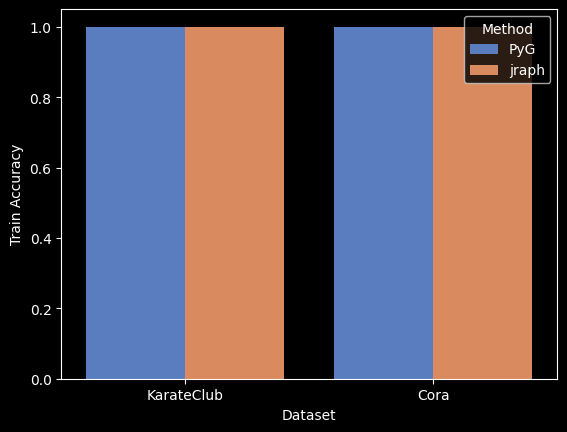

In [ ]:
df = pd.DataFrame(accuracy_list, columns=('Method', 'Dataset', 'Train Accuracy'))
sns.barplot(df,x='Dataset', y='Train Accuracy', hue='Method', palette="muted")
plt.show()

## Checking Test Accuracy

In [ ]:
test_acc = test(data_Cora, data_Cora.test_mask)
test_acc

0.782

In [ ]:
decoded_graph = network.apply(graph_params, graph)
correct = jnp.argmax(decoded_graph.nodes[graph_test_mask], axis=1) == graph_labels[graph_test_mask]  # Check against ground-truth labels.
acc = int(correct.sum()) / int(graph_test_mask.sum())  # Derive ratio of correct predictions.
acc

0.728